In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
from kernels.utils import clone_grads, paramdot
import torch
from torch import nn

## Generate data

In [2]:
import math
sin_wave = np.array([math.sin(x) for x in np.arange(200)])
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len
val_num = 100
for i in range(num_records):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

inps = X[:3]
inpcov = np.einsum('ais,bjs->aibj', inps, inps) / inps.shape[-1]

## Compare finite NTK and infinite NTK

In [3]:
from kernels.utils import VReLU, VStep, paramdot, clone_grads, getCor
from itertools import product
from models import Transformer

def NTK_theory_vs_sim(seqs, infntk,
                    depth,
                    log2widthmin=6, log2widthmax=14, nseeds=10):
    if isinstance(seqs, np.ndarray):
        seqs = torch.from_numpy(seqs).float()
    M = seqs.shape[0]
    inputdim = seqs.shape[-1]
    infntknorm = np.linalg.norm(infntk)
    frobs = []
    widths = 2**np.arange(log2widthmin, log2widthmax)

    for width, seed in tqdm(list(product(widths, range(nseeds)))):
        torch.manual_seed(seed)
        trsfmr = Transformer(depth=depth, d_in=inputdim, d=width)
        grads = []
        for seq in seqs:
            trsfmr.zero_grad()
            trsfmr.reset_data()
            out = trsfmr(seq)
            out.backward()
            grads.append(clone_grads(trsfmr))

        finntk = torch.zeros(M, M)
        for i in range(M):
            for j in range(i+1):
                finntk[i, j] = finntk[j, i] = paramdot(grads[i], grads[j])

        frobs.append(dict(
            width=width,
            relfrob=np.linalg.norm(finntk-infntk) / infntknorm
        ))
    return pd.DataFrame(frobs)

In [4]:
from kernels import RNTK,TNTK
depth = 1
inf_ntk = TNTK(inpcov, depth)
frob_df = NTK_theory_vs_sim(inps, inf_ntk, depth=depth,
                            log2widthmax=14, nseeds=100)

100%|█████████████████████████████████████████| 800/800 [05:26<00:00,  2.45it/s]


## Plot the deviation of finite NTK from infinite NTK

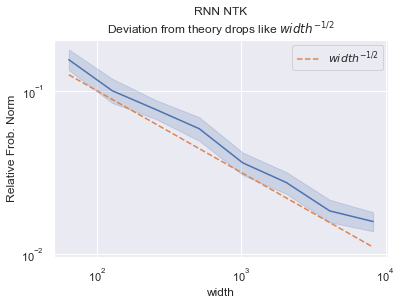

In [5]:
sns.lineplot(data=frob_df, x='width', y='relfrob')
widths = frob_df.width.unique()
plt.plot(widths, np.array(widths, dtype='float')**-0.5, '--', label=u'${width}^{-1/2}$')
plt.ylabel(u'Relative Frob. Norm')
plt.loglog()
plt.legend()
_ = plt.title(u'RNN NTK\nDeviation from theory drops like $width^{-1/2}$')

In [6]:
frob_df.to_pickle('output/transformer_ntk.frob')

## Plot all models on the same figure

In [7]:
import pandas as pd

rnn_df = pd.read_pickle('output/rnn_ap_ntk.frob')
gnn_df = pd.read_pickle('output/gnn_ntk.frob')
rnn_df

,relfrob,width
0,0.526477,64
1,0.480429,64
2,0.006027,64
3,0.238426,64
4,0.473248,64
...,...,...
795,0.012992,8192
796,0.052809,8192
797,0.020411,8192
798,0.032961,8192


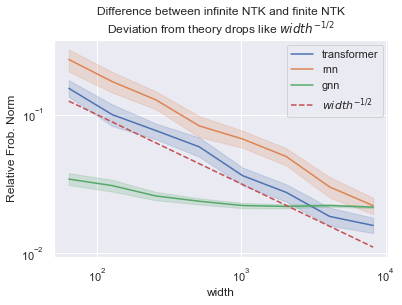

In [8]:
sns.lineplot(data=frob_df, x='width', y='relfrob', label="transformer")
sns.lineplot(data=rnn_df, x='width', y='relfrob', label="rnn")
sns.lineplot(data=gnn_df, x='width', y='relfrob', label="gnn")

widths = frob_df.width.unique()
plt.plot(widths, np.array(widths, dtype='float')**-0.5, '--', label=u'${width}^{-1/2}$')
plt.ylabel(u'Relative Frob. Norm')
plt.loglog()
plt.legend()
_ = plt.title(u'Difference between infinite NTK and finite NTK\nDeviation from theory drops like $width^{-1/2}$')